# Regression

In [1]:
import geopandas as gpd

blocks_gdf = gpd.read_parquet('/root/blocksnet/tests/data/blocks.parquet')

In [2]:
blocks_gdf = blocks_gdf.fillna(0)

In [3]:
blocks_gdf = blocks_gdf[(blocks_gdf[['fsi', 'gsi']] > 0).all(axis=1)]

In [4]:
columns_to_change = ['residential', 'business', 'recreation', 'industrial',
       'transport', 'special','agriculture']  # укажите нужные колонки

blocks_gdf[columns_to_change] = blocks_gdf[columns_to_change].clip(upper=1)

In [5]:
blocks_gdf = blocks_gdf.reset_index()

In [6]:
from blocksnet.relations import generate_adjacency_graph

adjacency_graph = generate_adjacency_graph(blocks_gdf, 10)

2025-04-10 16:39:24.277 | INFO     | blocksnet.relations.adjacency.core:_generate_adjacency_nodes:10 - Generating nodes
2025-04-10 16:39:24.280 | INFO     | blocksnet.relations.adjacency.core:_generate_adjacency_edges:15 - Generating edges
2025-04-10 16:39:24.665 | SUCCESS  | blocksnet.relations.adjacency.core:generate_adjacency_graph:34 - Adjacency graph successfully generated: 6109 nodes, 5892 edges


## Density

In [7]:
from blocksnet.machine_learning.regression import DensityRegressor

dr = DensityRegressor()

/root/blocksnet/.venv/lib/python3.12/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: libcudart.so.11.0: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/root/blocksnet/.venv/lib/python3.12/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: libcudart.so.11.0: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


### Train

In [8]:
from shapely.geometry import box

total_bounds = blocks_gdf.total_bounds  # [xmin, ymin, xmax, ymax]
x_min, y_min, x_max, y_max = total_bounds

# Вычисляем центр области
center_x = (x_min + x_max) / 2
center_y = (y_min + y_max) / 2

# Определяем размер квадрата (20% от минимальной размерности экстента)
extent_width = x_max - x_min
extent_height = y_max - y_min
square_size = min(extent_width, extent_height) * 0.1

# Задаем смещение вправо по X (например, 30% от размера квадрата)
shift_x = square_size * 1.1 # Можно настроить это значение

# Вычисляем координаты квадрата со смещением
half_size = square_size / 2
xmin = center_x - half_size + shift_x  # Смещаем вправо
xmax = center_x + half_size + shift_x  # Смещаем вправо
ymin = center_y - half_size
ymax = center_y + half_size

# Создаем квадрат
square = box(xmin, ymin, xmax, ymax)

# Получаем булеву маску и подмножества
intersects_mask = blocks_gdf.geometry.intersects(square)
blocks_gdf_inside = blocks_gdf[intersects_mask]
blocks_gdf_outside = blocks_gdf[~intersects_mask]

# Индексы
inside_indices = blocks_gdf_inside.index
outside_indices = blocks_gdf_outside.index

In [9]:
data = dr.get_train_data(blocks_gdf, adjacency_graph, fit_scaler=True, train_indices=outside_indices, test_indices=inside_indices)

2025-04-10 16:39:26.969 | INFO     | blocksnet.preprocessing.feature_engineering.core:_calculate_usual_features:34 - Calculating usual features
2025-04-10 16:39:27.124 | INFO     | blocksnet.machine_learning.regression.density.core:_features_from_geometries:32 - Fitting the scaler


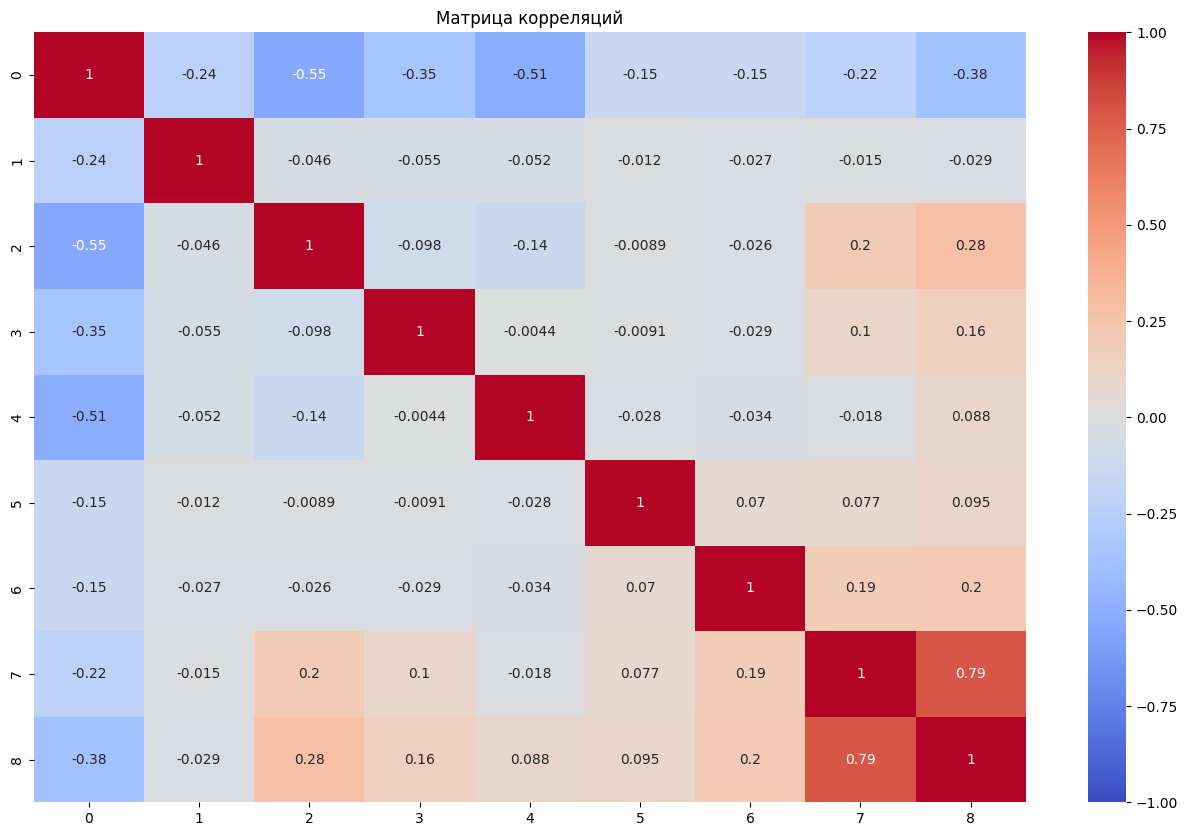

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from blocksnet.machine_learning.regression.density.schemas import BlocksLandUseSchema, BlocksGeometriesSchema, BlocksDensitiesSchema

numpy_data = data.x.numpy()

df = pd.DataFrame(numpy_data)
correlation_matrix = df.corr()

plt.figure(figsize=(16, 10)) 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Матрица корреляций')  
plt.show()

In [11]:
train_losses, val_losses = dr.train(data, epochs=5000, learning_rate=3e-4, weight_decay=0)

Train loss: 0.00442 | Val loss: 0.01443: 100%|██████████| 5000/5000 [03:58<00:00, 20.92it/s] 


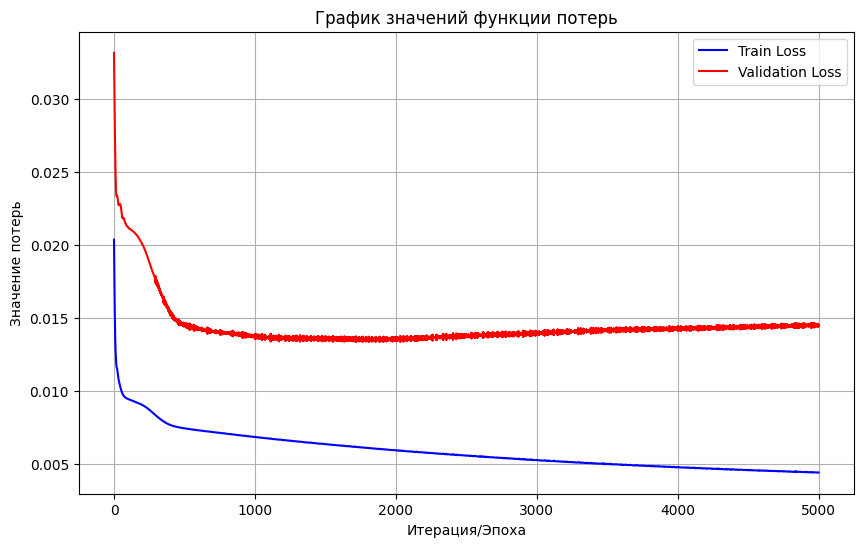

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Создаем массив для оси X (эпохи или итерации)
x = np.arange(len(train_losses))

# Создаем график
plt.figure(figsize=(10, 6))  # задаем размер графика
plt.plot(x, train_losses, 'b-', label='Train Loss')  # синяя линия для тренировочных потерь
plt.plot(x, val_losses, 'r-', label='Validation Loss')  # красная линия для валидационных потерь

# Настраиваем график
plt.title('График значений функции потерь')
plt.xlabel('Итерация/Эпоха')
plt.ylabel('Значение потерь')
plt.grid(True)  # добавляем сетку
plt.legend()  # добавляем легенду

# Показываем график
plt.show()

### Test

In [13]:
dr.test(data)

0.014433635398745537

### Evaluate

In [14]:
result_df = dr.evaluate(blocks_gdf, adjacency_graph)

2025-04-10 16:43:24.668 | INFO     | blocksnet.preprocessing.feature_engineering.core:_calculate_usual_features:34 - Calculating usual features


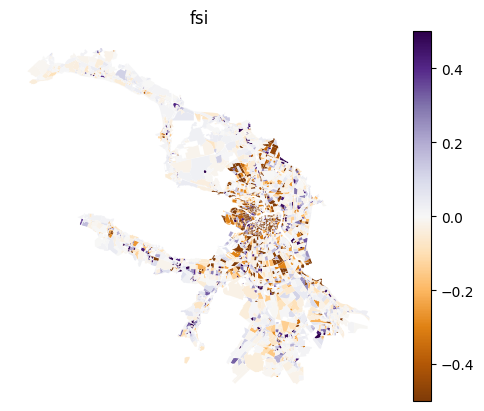

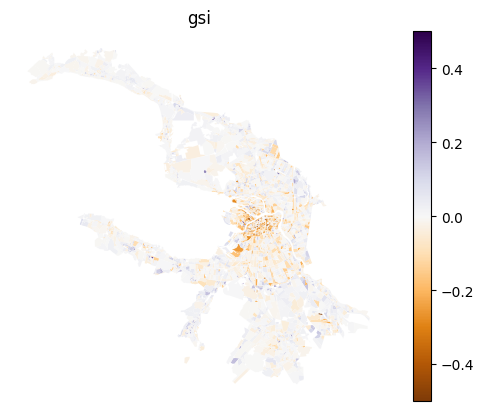

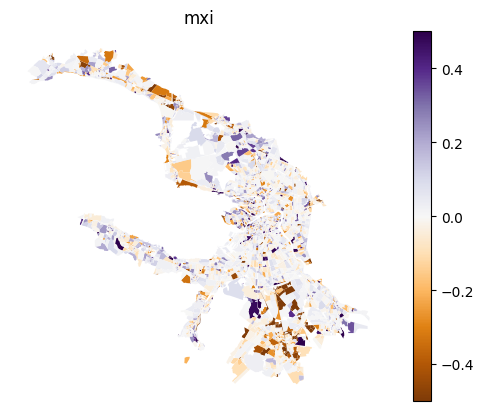

In [15]:
df = result_df.copy()
for column in df.columns:
  df[column] -= blocks_gdf[column]
  ax = blocks_gdf[['geometry']].join(df).plot(column, cmap='PuOr', legend=True, vmin=-0.5, vmax=0.5)
  ax.set_title(column)
  ax.set_axis_off()

## Save model and scaler

In [18]:
dr.save_model('model.dict')
dr.save_scaler('scaler.save')